In [10]:
import pandas as pd

df = pd.read_csv('../data/raw/clinvar_conflicting.csv',
                 dtype={'CHROM': str})

/var/folders/tl/5pdn6vld70l0ndj9lvltyvxw0000gn/T/ipykernel_28765/2493428773.py:3: DtypeWarning: Columns (38,40) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('../data/raw/clinvar_conflicting.csv',


In [13]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("whitegrid")
sns.set_context("notebook")

Matplotlib is building the font cache; this may take a moment.


In [14]:
df.shape
df.info()
df.isnull().sum().sort_values(ascending=False)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 65188 entries, 0 to 65187
Data columns (total 46 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   CHROM               65188 non-null  object 
 1   POS                 65188 non-null  int64  
 2   REF                 65188 non-null  object 
 3   ALT                 65188 non-null  object 
 4   AF_ESP              65188 non-null  float64
 5   AF_EXAC             65188 non-null  float64
 6   AF_TGP              65188 non-null  float64
 7   CLNDISDB            65188 non-null  object 
 8   CLNDISDBINCL        167 non-null    object 
 9   CLNDN               65188 non-null  object 
 10  CLNDNINCL           167 non-null    object 
 11  CLNHGVS             65188 non-null  object 
 12  CLNSIGINCL          167 non-null    object 
 13  CLNVC               65188 non-null  object 
 14  CLNVI               27659 non-null  object 
 15  MC                  64342 non-null  object 
 16  ORIG

MOTIF_SCORE_CHANGE    65186
HIGH_INF_POS          65186
MOTIF_POS             65186
MOTIF_NAME            65186
DISTANCE              65080
SSR                   65058
CLNSIGINCL            65021
CLNDISDBINCL          65021
CLNDNINCL             65021
INTRON                56385
PolyPhen              40392
SIFT                  40352
BLOSUM62              39595
CLNVI                 37529
BAM_EDIT              33219
Codons                10004
Amino_acids           10004
Protein_position       9955
CDS_position           9955
EXON                   8893
cDNA_position          8884
LoFtool                4213
CADD_PHRED             1092
CADD_RAW               1092
MC                      846
SYMBOL                   16
BIOTYPE                  16
STRAND                   14
Feature_type             14
Feature                  14
CLNDN                     0
REF                       0
ALT                       0
AF_ESP                    0
AF_EXAC                   0
AF_TGP              

<Axes: xlabel='CLASS', ylabel='count'>

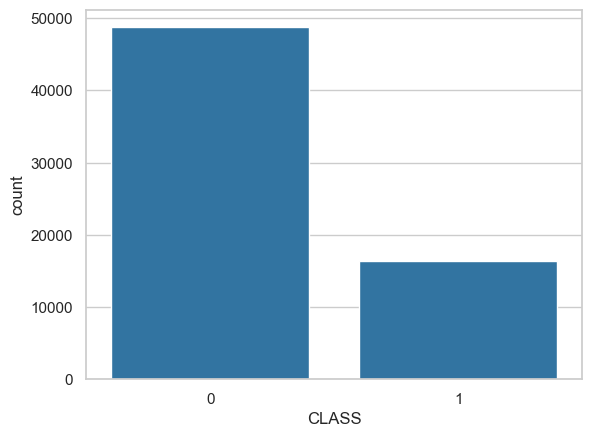

In [15]:
sns.countplot(x="CLASS", data=df)

In [16]:
df.CHROM.value_counts()

CHROM
2     8645
17    5394
11    4846
1     4454
16    3927
19    3911
5     3643
7     2867
12    2750
9     2744
13    2646
3     2529
10    2341
6     2159
14    1974
X     1926
8     1852
15    1725
4     1206
22    1135
18     896
21     843
20     759
MT      16
Name: count, dtype: int64

In [17]:
pd.crosstab(df.SYMBOL, df.CLASS)

CLASS,0,1
SYMBOL,,
A2ML1,19,2
AAAS,1,1
AARS,27,14
AARS2,13,8
ABAT,6,5
...,...,...
ZNF423,17,2
ZNF469,78,34
ZNF674,1,1


In [18]:
pd.crosstab(df.SIFT, df.CLASS)
pd.crosstab(df.PolyPhen, df.CLASS)

CLASS,0,1
PolyPhen,,
benign,9836,3493
possibly_damaging,2894,1038
probably_damaging,5552,1979
unknown,2,2


<Axes: xlabel='AF_EXAC', ylabel='Count'>

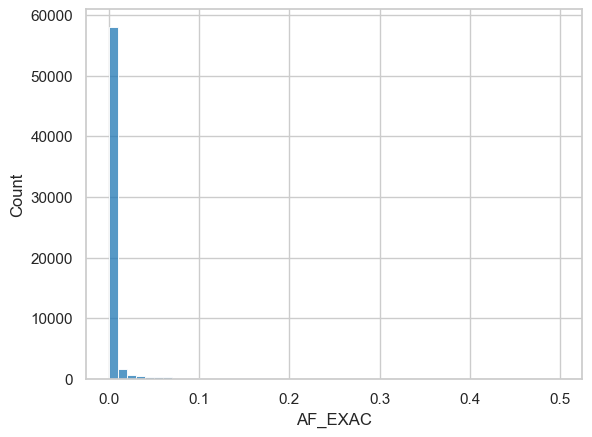

In [19]:
sns.histplot(df.AF_EXAC, bins=50)

<Axes: xlabel='CLASS', ylabel='AF_EXAC'>

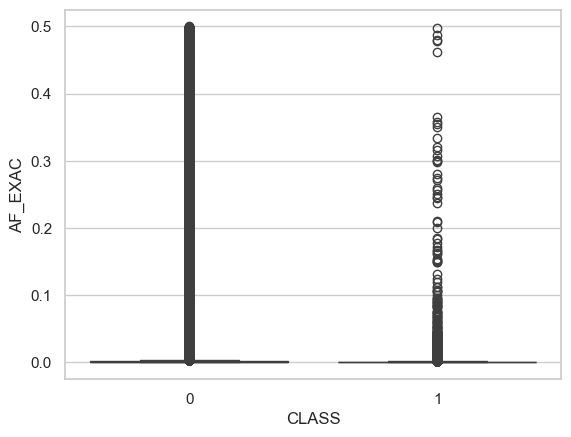

In [20]:
sns.boxplot(x="CLASS", y="AF_EXAC", data=df)

In [21]:
import numpy as np
import pandas as pd
import re

# Longituds
df["REF_length"] = df["REF"].astype(str).str.len()
df["ALT_length"] = df["ALT"].astype(str).str.len()
df["Allele_length"] = df["Allele"].astype(str).str.len()

# SNV vs indel
df["SNV"] = ((df["REF_length"] == 1) & (df["ALT_length"] == 1)).astype(int)

# CLNDN binari
df["CLNDN_not_specified"] = df["CLNDN"].isin(
    ["not_specified", "not_provided", "not_specified|not_provided"]
).astype(int)

# Exon / Intron flags
df["Is_Exon"] = df["EXON"].notna().astype(int)
df["Is_Intron"] = df["INTRON"].notna().astype(int)

In [22]:
def parse_fraction(x):
    # "4/39" -> (4, 39)
    if pd.isna(x):
        return (np.nan, np.nan)
    m = re.search(r"(\d+)\s*/\s*(\d+)", str(x))
    return (float(m.group(1)), float(m.group(2))) if m else (np.nan, np.nan)

exon_parsed = df["EXON"].apply(parse_fraction)
df["EXON_position"] = exon_parsed.apply(lambda t: t[0])
df["EXON_length"] = exon_parsed.apply(lambda t: t[1])

In [23]:
def parse_start_stop(x):
    # "123-125" -> (123,125), "123" -> (123,123)
    if pd.isna(x):
        return (np.nan, np.nan)
    s = str(x)
    parts = s.split("-")
    try:
        a = float(parts[0])
        b = float(parts[-1])
        return (a, b)
    except:
        return (np.nan, np.nan)

for col in ["cDNA_position", "CDS_position", "Protein_position"]:
    start_stop = df[col].apply(parse_start_stop)
    df[f"{col}_start"] = start_stop.apply(lambda t: t[0])
    df[f"{col}_stop"] = start_stop.apply(lambda t: t[1])

In [24]:
missing = (df.isna().mean().sort_values(ascending=False) * 100)
missing.head(15)

MOTIF_NAME            99.996932
MOTIF_POS             99.996932
MOTIF_SCORE_CHANGE    99.996932
HIGH_INF_POS          99.996932
DISTANCE              99.834325
SSR                   99.800577
CLNSIGINCL            99.743818
CLNDNINCL             99.743818
CLNDISDBINCL          99.743818
INTRON                86.495981
PolyPhen              61.962324
SIFT                  61.900963
BLOSUM62              60.739707
CLNVI                 57.570412
BAM_EDIT              50.958765
dtype: float64

In [25]:
class_counts = df["CLASS"].value_counts()
class_counts, (class_counts[1] / class_counts.sum())

(CLASS
 0    48754
 1    16434
 Name: count, dtype: int64,
 np.float64(0.2521016137939498))

In [26]:
(df.groupby("CLNVC")["CLASS"].mean().sort_values(ascending=False)).head(20)
(df.groupby("IMPACT")["CLASS"].mean().sort_values(ascending=False))

IMPACT
LOW         0.267905
MODIFIER    0.266750
MODERATE    0.265145
HIGH        0.071759
Name: CLASS, dtype: float64

In [27]:
df.groupby("SNV")["CLASS"].mean()

SNV
0    0.187100
1    0.256246
Name: CLASS, dtype: float64

Counts:
 CLASS
0    48754
1    16434
Name: count, dtype: int64

Proportions:
 CLASS
0    74.79
1    25.21
Name: proportion, dtype: float64

Baseline accuracy (predict always majority class): 0.7479 (74.79%)


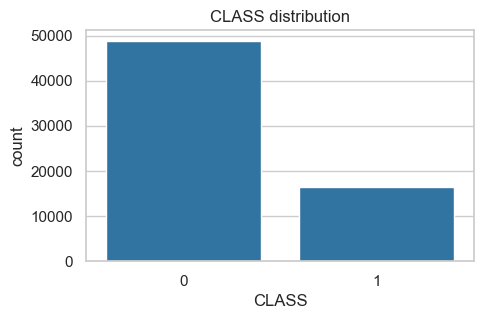

In [28]:
class_counts = df["CLASS"].value_counts().sort_index()
class_props = df["CLASS"].value_counts(normalize=True).sort_index()

print("Counts:\n", class_counts)
print("\nProportions:\n", (class_props * 100).round(2))

baseline_acc = class_props.max()
print(f"\nBaseline accuracy (predict always majority class): {baseline_acc:.4f} ({baseline_acc*100:.2f}%)")

plt.figure(figsize=(5,3))
sns.countplot(x="CLASS", data=df)
plt.title("CLASS distribution")
plt.show()

In [29]:
# Unicitat per coordenades
n_groups = df.groupby(["CHROM", "POS", "REF", "ALT"]).ngroups
print("Unique (CHROM,POS,REF,ALT) groups:", n_groups, " / rows:", len(df))
print("Is unique by (CHROM,POS,REF,ALT)?", n_groups == len(df))

# Unicitat per HGVS
if "CLNHGVS" in df.columns:
    print("CLNHGVS nunique:", df["CLNHGVS"].nunique(), " / rows:", len(df))
    print("Is CLNHGVS unique?", df["CLNHGVS"].nunique() == len(df))

Unique (CHROM,POS,REF,ALT) groups: 65188  / rows: 65188
Is unique by (CHROM,POS,REF,ALT)? True
CLNHGVS nunique: 65188  / rows: 65188
Is CLNHGVS unique? True


In [30]:
missing = pd.DataFrame({
    "missing_count": df.isna().sum(),
    "missing_pct": (df.isna().mean() * 100).round(2),
    "dtype": df.dtypes.astype(str),
    "nunique": df.nunique(dropna=True)
}).sort_values("missing_pct", ascending=False)

display(missing.head(25))

# Columnes a dropejar segons llindar
DROP_MISSING_PCT = 95.0
drop_cols = missing.index[missing["missing_pct"] >= DROP_MISSING_PCT].tolist()

print(f"Columns with >= {DROP_MISSING_PCT}% missing: {len(drop_cols)}")
print(drop_cols)

,missing_count,missing_pct,dtype,nunique
MOTIF_NAME,65186,100.00,object,2
MOTIF_POS,65186,100.00,float64,1
MOTIF_SCORE_CHANGE,65186,100.00,float64,2
HIGH_INF_POS,65186,100.00,object,1
DISTANCE,65080,99.83,float64,96
SSR,65058,99.80,float64,2
CLNSIGINCL,65021,99.74,object,137
CLNDNINCL,65021,99.74,object,101
CLNDISDBINCL,65021,99.74,object,93
INTRON,56385,86.50,object,1929


Columns with >= 95.0% missing: 9
['MOTIF_NAME', 'MOTIF_POS', 'MOTIF_SCORE_CHANGE', 'HIGH_INF_POS', 'DISTANCE', 'SSR', 'CLNSIGINCL', 'CLNDNINCL', 'CLNDISDBINCL']


,SIFT,PolyPhen,BLOSUM62
CLASS,,,
0,62.47,62.50,61.33
1,60.22,60.37,58.98


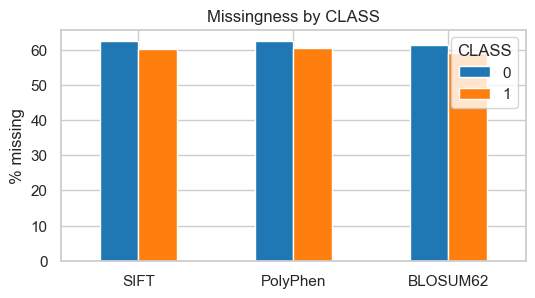

In [31]:
cols_to_check = [c for c in ["SIFT", "PolyPhen", "BLOSUM62"] if c in df.columns]

missing_by_class = {}
for col in cols_to_check:
    tmp = df.groupby("CLASS")[col].apply(lambda s: s.isna().mean()).rename(col)
    missing_by_class[col] = tmp

missing_by_class_df = pd.concat(missing_by_class.values(), axis=1)
missing_by_class_df = (missing_by_class_df * 100).round(2)
display(missing_by_class_df)

# Opcional: plot
missing_by_class_df.T.plot(kind="bar", figsize=(6,3))
plt.ylabel("% missing")
plt.title("Missingness by CLASS")
plt.xticks(rotation=0)
plt.show()

In [32]:
def parse_start_stop(x):
    """
    '258-260' -> (258.0, 260.0)
    '258' -> (258.0, 258.0)
    '?' o NaN -> (NaN, NaN)
    """
    if pd.isna(x):
        return (np.nan, np.nan)
    s = str(x).strip()
    if s == "" or s == "?":
        return (np.nan, np.nan)
    parts = s.split("-")
    try:
        a = float(parts[0])
        b = float(parts[-1])
        return (a, b)
    except:
        return (np.nan, np.nan)

pos_cols = [c for c in ["cDNA_position", "CDS_position", "Protein_position"] if c in df.columns]

for col in pos_cols:
    ss = df[col].apply(parse_start_stop)
    df[f"{col}_start"] = ss.apply(lambda t: t[0])
    df[f"{col}_stop"]  = ss.apply(lambda t: t[1])

# Quick sanity check
display(df[[*pos_cols, *(f"{c}_start" for c in pos_cols), *(f"{c}_stop" for c in pos_cols)]].head(5))

,cDNA_position,CDS_position,Protein_position,cDNA_position_start,CDS_position_start,Protein_position_start,cDNA_position_stop,CDS_position_stop,Protein_position_stop
0,552,522,174,552.0,522.0,174.0,552.0,522.0,174.0
1,523,509,170,523.0,509.0,170.0,523.0,509.0,170.0
2,632,239,80,632.0,239.0,80.0,632.0,239.0,80.0
3,132,100,34,132.0,100.0,34.0,132.0,100.0,34.0
4,132,100,34,132.0,100.0,34.0,132.0,100.0,34.0


In [33]:
def parse_fraction_xy(x):
    """
    '4/39' -> (4.0, 39.0, 4/39)
    NaN/altres -> (NaN, NaN, NaN)
    """
    if pd.isna(x):
        return (np.nan, np.nan, np.nan)
    s = str(x).strip()
    m = re.search(r"(\d+)\s*/\s*(\d+)", s)
    if not m:
        return (np.nan, np.nan, np.nan)
    num = float(m.group(1))
    den = float(m.group(2))
    ratio = num/den if den != 0 else np.nan
    return (num, den, ratio)

for col in [c for c in ["EXON", "INTRON"] if c in df.columns]:
    parsed = df[col].apply(parse_fraction_xy)
    df[f"{col}_index"] = parsed.apply(lambda t: t[0])
    df[f"{col}_total"] = parsed.apply(lambda t: t[1])
    df[f"{col}_ratio"] = parsed.apply(lambda t: t[2])

display(df[[c for c in df.columns if c.startswith("EXON_") or c.startswith("INTRON_")]].head(5))

,EXON_position,EXON_length,EXON_index,EXON_total,EXON_ratio,INTRON_index,INTRON_total,INTRON_ratio
0,1.0,1.0,1.0,1.0,1.000000,NaN,NaN,NaN
1,4.0,4.0,4.0,4.0,1.000000,NaN,NaN,NaN
2,6.0,12.0,6.0,12.0,0.500000,NaN,NaN,NaN
3,1.0,7.0,1.0,7.0,0.142857,NaN,NaN,NaN
4,1.0,7.0,1.0,7.0,0.142857,NaN,NaN,NaN


In [34]:
cat_cols = df.select_dtypes(include=["object"]).columns.tolist()

card = pd.DataFrame({
    "col": cat_cols,
    "nunique": [df[c].nunique(dropna=True) for c in cat_cols],
    "missing_pct": [df[c].isna().mean()*100 for c in cat_cols],
}).sort_values("nunique", ascending=False)

display(card.head(20))

LOW_CARD_MAX = 20
low_card = card.loc[card["nunique"] <= LOW_CARD_MAX, "col"].tolist()
high_card = card.loc[card["nunique"] > LOW_CARD_MAX, "col"].tolist()

print("Low-cardinality (<=20):", len(low_card))
print(low_card)
print("\nHigh-cardinality (>20):", len(high_card))
print(high_card[:20], "...")

,col,nunique,missing_pct
7,CLNHGVS,65188,0.000000
10,CLNVI,27654,57.570412
21,cDNA_position,13970,13.628275
22,CDS_position,13663,15.271216
5,CLNDN,9260,0.000000
3,CLNDISDB,9234,0.000000
23,Protein_position,7339,15.271216
19,EXON,3264,13.642081
17,Feature,2369,0.021476
15,SYMBOL,2328,0.024544


Low-cardinality (<=20): 9
['CLNVC', 'IMPACT', 'SIFT', 'PolyPhen', 'BIOTYPE', 'Feature_type', 'BAM_EDIT', 'MOTIF_NAME', 'HIGH_INF_POS']

High-cardinality (>20): 22
['CLNHGVS', 'CLNVI', 'cDNA_position', 'CDS_position', 'CLNDN', 'CLNDISDB', 'Protein_position', 'EXON', 'Feature', 'SYMBOL', 'Codons', 'INTRON', 'Amino_acids', 'REF', 'ALT', 'Allele', 'CLNSIGINCL', 'CLNDNINCL', 'CLNDISDBINCL', 'MC'] ...


In [35]:
# nunique==1 (inclou object i numerics)
singleton_cols = [c for c in df.columns if df[c].nunique(dropna=True) <= 1]
print("Singleton columns (nunique<=1):", len(singleton_cols))
print(singleton_cols)

# zero variance per numerics (std == 0) - ignorar NaNs
num_cols = df.select_dtypes(include=[np.number]).columns
zero_var_cols = []
for c in num_cols:
    s = df[c].dropna()
    if len(s) > 0 and s.std() == 0:
        zero_var_cols.append(c)

print("\nZero-variance numeric columns:", len(zero_var_cols))
print(zero_var_cols)

Singleton columns (nunique<=1): 2
['MOTIF_POS', 'HIGH_INF_POS']

Zero-variance numeric columns: 1
['MOTIF_POS']
